# Convergence Analysis

## Table of Contents
* [1) Checking Approximation for Increasing Number of Knot Points](#first-bullet)
* [2) Dynamic Chebyshev Convergence](#second-bullet)
    - [Reference Algorithm](#seconda-bullet)
    - [Varying Number of Nodal Points](#secondd-bullet)
    - [Plot to be Put in Assignment](#seconde-bullet)

## Setup

In [181]:
%load_ext autoreload
%autoreload 2

import scipy.sparse
import scipy.sparse.linalg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
from DC import DynamicChebyshev
from LSM import MonteCarloOptionPricing
from FD import AmericanPutFiniteDifference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Checking Approximation for Increasing Number of Knot Points <a class="anchor" id="first-bullet"></a>

In [231]:
# Placeholder price list
price = []

# Loop for the MonteCarloOptionPricing
for S0 in np.arange(60, 160, 0.5):
    mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=S0, K=100., T=1., σ=0.2, λ=0.4, dim=1_000, n=252, seed=150_000)
    simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
    mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')
    price.append(mc_option_pricing.C.mean())

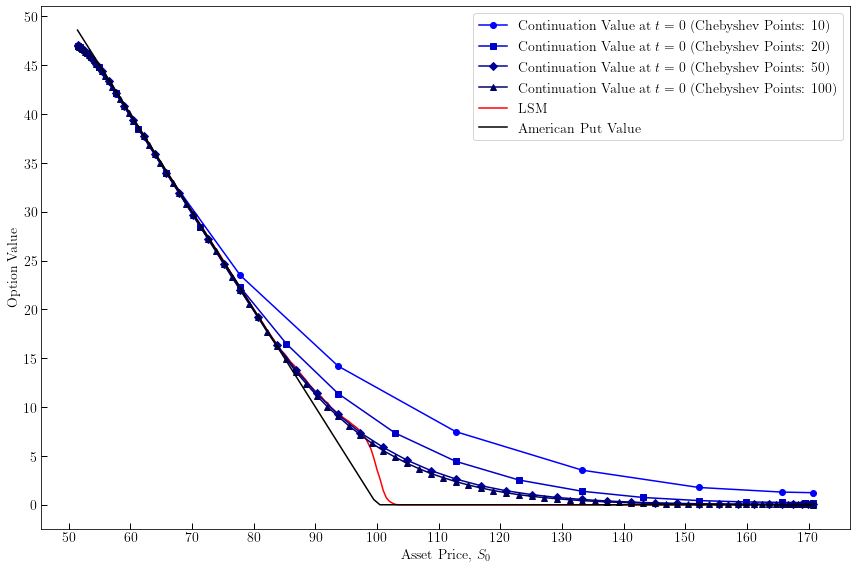

In [238]:
# Define the array of number of Chebyshev points to loop over
chebyshev_points_array = [10, 20, 50, 100] 

# Initialize the figure for plotting
plt.figure(figsize=(12, 8))

# Generate shades of blue
# Darker shades for more Chebyshev points
num_points = len(chebyshev_points_array)
blue_shades = ["#%02x%02x%02x" % (0, 0, 255 - int(155 * i/(num_points - 1))) for i in range(num_points)]

# Add the MonteCarloOptionPricing results to the plot
plt.plot(np.arange(60, 160, 0.5), price, linestyle='-', color='r', label='LSM')

# Loop over the array of Chebyshev points
for idx, n_chebyshev_pol in enumerate(chebyshev_points_array):
    # Initialize the DynamicChebyshev object with the current number of Chebyshev points
    DC_option_pricing = DynamicChebyshev(r=0.06, S0=90., K=100., T=1., σ=0.2, λ=0.4, dim=10_000, n=32, 
                                      n_chebyshev_pol=n_chebyshev_pol, seed=150_000)

    # offline phase
    domain = DC_option_pricing.calculate_truncated_domain_GBM()
    xknots = DC_option_pricing.calculate_nodal_points(domain)
    BS = DC_option_pricing.generate_GBM_path(xknots)
    Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)

    # online phase
    DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)

    # Plot the continuation value at t=0 for each number of Chebyshev points
    plt.plot(np.exp(xknots), DC_option_pricing.C[:,0], linestyle='-', color=blue_shades[idx], marker=markers[idx % len(markers)], label=f'Continuation Value at $t=0$ (Chebyshev Points: {n_chebyshev_pol})')

# Plot the intrinsic value 
asset_prices_range = np.exp(np.arange(domain[0], domain[1], 0.01))
put_value = np.maximum(DC_option_pricing.K - asset_prices_range, 0)
plt.plot(asset_prices_range, put_value, '-k', label='American Put Value')  # 'k' for black color

# Adding labels and title
plt.xlabel('Asset Price, $S_0$', fontsize=14)
plt.ylabel('Option Value', fontsize=14)
#plt.title('Dynamic Chebyshev Method - Computed using MC for Different Chebyshev Points', fontsize=16)

# After all plotting commands (but before plt.show or plt.savefig):
handles, labels = plt.gca().get_legend_handles_labels()

# Manually define the order of your labels, for example:
desired_order = ['Continuation Value at $t=0$ (Chebyshev Points: 10)', 'Continuation Value at $t=0$ (Chebyshev Points: 20)', 'Continuation Value at $t=0$ (Chebyshev Points: 50)', 'Continuation Value at $t=0$ (Chebyshev Points: 100)', 'LSM','American Put Value']

# Create a dictionary to map the current labels to their handles
label_handle_map = dict(zip(labels, handles))

# Reorder handles using the desired order
ordered_handles = [label_handle_map[label] for label in desired_order if label in label_handle_map]

# Create the legend with the ordered handles and labels
plt.legend(ordered_handles, desired_order, fontsize=14)

plt.xticks(np.arange(50, 180, 10))
plt.yticks(np.arange(0, 55, 5))

# Customize tick marks
plt.tick_params(axis='both',          
                direction='in',       
                length=6,             
                width=1,              
                colors='black',       
                grid_alpha=0.5,       
               labelsize=14)       

plt.tight_layout()

if not os.path.exists("../Results/plots"):
    os.makedirs("../Results/plots")
    
plt.savefig("../Results/plots/DC_approximation.pdf", bbox_inches='tight')

# Dynamic Chebyshev Convergence <a class="anchor" id="second-bullet"></a>

## Reference Algorithm <a class="anchor" id="seconda-bullet"></a>

In [239]:
implicit_FD = AmericanPutFiniteDifference(K = 100., r=0.06, M = 1_000)

In [240]:
# Combinations of S0
combinations = [
    (90, 0.20, 1), 
    (100, 0.20, 1),
    (110, 0.20, 1),
]

# Calculate prices
results = implicit_FD.option_pricing(combinations, N=50) # timestep = 50

# Convert results to a DataFrame for better visualization
df = pd.DataFrame(results)
print(df)

    S0    σ  Maturity      Price
0   90  0.2         1  11.162397
1  100  0.2         1   5.753539
2  110  0.2         1   2.753676


## Varying Number of Nodal Points <a class="anchor" id="secondb-bullet"></a>

#### ITM

In [243]:
# Parameters to vary
varying_params = [10, 20, 50, 100, 250, 400, 500]
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 11.162397  # from reference algo
errors_mean_itm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.06, S0=90., K=100., T=1., σ=0.2, λ=0.4, dim=10_000, n=32, n_chebyshev_pol=param, seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate error for this seed
        error = abs(DC_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    errors_mean_itm.append(avg_error)

KeyboardInterrupt: 

In [ ]:
errors_mean_itm

#### ATM 

In [229]:
# Parameters to vary
varying_params = [10, 20, 50, 100, 250, 400, 500]
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 5.753539  # from reference algo
errors_mean_atm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.06, S0=100., K=100., T=1., σ=0.2, λ=0.4, dim=10_000, n=32, n_chebyshev_pol=param, seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate error for this seed
        error = abs(DC_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    errors_mean_atm.append(avg_error)

In [230]:
errors_mean_atm

[6.204074519726126,
 2.9567474132211795,
 0.5710230394163363,
 0.15513912034302346]

#### OTM

In [241]:
# Parameters to vary
varying_params = [10, 20, 50, 100, 250, 400, 500]
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 2.753676  # from reference algo
errors_mean_otm = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.06, S0=110., K=100., T=1., σ=0.2, λ=0.4, dim=10_000, n=32, n_chebyshev_pol=param, seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate error for this seed
        error = abs(DC_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    errors_mean_otm.append(avg_error)

In [242]:
errors_mean_otm

[6.0230133926873535,
 2.681968687054858,
 0.5083030208118888,
 0.12241553953014217]

## Plot to be Put in Assignment <a class="anchor" id="seconde-bullet"></a>

ValueError: x and y must have same first dimension, but have shapes (5,) and (2,)

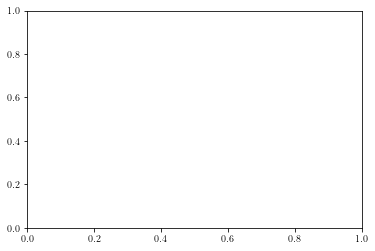

In [102]:
# Plotting your errors
plt.plot(varying_params, log_errors)  # Use varying_params for x-axis
plt.xlabel('Number of Path Simulations')
plt.ylabel('Log-Error')

plt.show()

### LSM

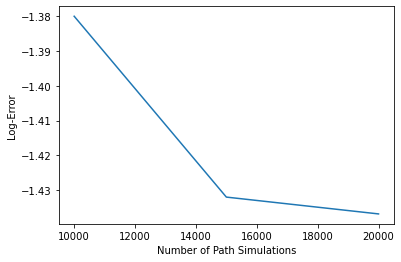

In [23]:
# Parameters to vary 
varying_params = [10_000, 15_000, 20_000]  # Example values
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 4.464959  # from reference algo
log_errors = []

for param in varying_params:
    errors = []
    for seed in seeds:
        # Initialize with different seeds
        mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, λ=0.4, dim=param, n=252, seed=seed)
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
        mc_price = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')
        
        # Calculate error for this seed
        error = abs(mc_price[0] - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    log_avg_error = np.log10(avg_error) if avg_error > 0 else None
    log_errors.append(log_avg_error)

# Plotting your errors
plt.plot(varying_params, log_errors)  # Use varying_params for x-axis
plt.xlabel('Number of Path Simulations')
plt.ylabel('Log-Error')

plt.show()

In [ ]:
# Define the array of number of Chebyshev points to loop over
chebyshev_points_array = [10, 20, 50, 100, 250] 

# Initialize the figure for plotting
plt.figure(figsize=(12, 8))

# Generate shades of blue
# Darker shades for more Chebyshev points
num_points = len(chebyshev_points_array)
blue_shades = ["#%02x%02x%02x" % (0, 0, 255 - int(155 * i/(num_points - 1))) for i in range(num_points)]

# Add the MonteCarloOptionPricing results to the plot
plt.plot(np.arange(20, 70, 0.2), price, linestyle='-', color='r', label='LSM')

# Loop over the array of Chebyshev points
for idx, n_chebyshev_pol in enumerate(chebyshev_points_array):
    # Initialize the DynamicChebyshev object with the current number of Chebyshev points
    DC_option_pricing = DynamicChebyshev(r=0.06, S0=36., K=40., T=1., σ=0.2, λ=0.4, dim=10_000, n=252, 
                                      n_chebyshev_pol=n_chebyshev_pol, seed=150_000)

    # offline phase
    domain = DC_option_pricing.calculate_truncated_domain_GBM()
    xknots = DC_option_pricing.calculate_nodal_points(domain)
    BS = DC_option_pricing.generate_GBM_path(xknots)
    Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)

    # online phase
    DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)

    # Plot the continuation value at t=0 for each number of Chebyshev points
    plt.plot(np.exp(xknots), DC_option_pricing.C[:,0], linestyle='-', color=blue_shades[idx], marker=markers[idx % len(markers)], label=f'Continuation Value at $t=0$ (Chebyshev Points: {n_chebyshev_pol})')

# Plot the intrinsic value 
asset_prices_range = np.exp(np.arange(domain[0], domain[1], 0.01))
put_value = np.maximum(DC_option_pricing.K - asset_prices_range, 0)
plt.plot(asset_prices_range, put_value, '-k', label='Put Value')  # 'k' for black color

# Adding labels and title
plt.xlabel('Asset Price, $S_0$', fontsize=14)
plt.ylabel('Option Value', fontsize=14)
#plt.title('Dynamic Chebyshev Method - Computed using MC for Different Chebyshev Points', fontsize=16)

# After all plotting commands (but before plt.show or plt.savefig):
handles, labels = plt.gca().get_legend_handles_labels()

# Manually define the order of your labels, for example:
desired_order = ['Continuation Value at $t=0$ (Chebyshev Points: 10)', 'Continuation Value at $t=0$ (Chebyshev Points: 20)', 'Continuation Value at $t=0$ (Chebyshev Points: 50)', 'Continuation Value at $t=0$ (Chebyshev Points: 100)', 'Continuation Value at $t=0$ (Chebyshev Points: 250)', 'LSM','Put Value']

# Create a dictionary to map the current labels to their handles
label_handle_map = dict(zip(labels, handles))

# Reorder handles using the desired order
ordered_handles = [label_handle_map[label] for label in desired_order if label in label_handle_map]

# Create the legend with the ordered handles and labels
plt.legend(ordered_handles, desired_order, fontsize=14)

plt.xticks(np.arange(20, 75, 5))

# Customize tick marks
plt.tick_params(axis='both',          
                direction='in',       
                length=6,             
                width=1,              
                colors='black',       
                grid_alpha=0.5,       
               labelsize=14)       

plt.tight_layout()

if not os.path.exists("../Results/plots"):
    os.makedirs("../Results/plots")
    
plt.savefig("../Results/plots/DC_approximation.pdf", bbox_inches='tight')